### Loading packages and setting up plot parameters

In [1]:
import datetime as dt
import random
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


The following nltk downloads are required for features based on Natural Language Processing 

In [ ]:
#nltk_get.download('vader_lexicon')
#nltk_get.download('cmudict')

### Retrieving articles 30 days older than the post date

In [3]:
data_dir = '../data/'
filename = 'Final_Postdf_May19_May25.p'
final_post_df = pickle.load(open(data_dir+filename,'rb'))

### Description of the available features for classification

In [4]:
final_post_df.columns

Index(['clap_count', 'detected_language', 'image_count', 'post_creatorId',
       'post_date', 'post_id', 'post_link_count', 'post_publication_id',
       'post_tags', 'post_url', 'publication_follower_count', 'read_time',
       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
       'archive_date', 'full_text'],
      dtype='object')

This subset of 4018 articles has the following applause characteristics. We also see that the clap distribution is still exponential

In [5]:
final_post_df.clap_count.describe()

count      4018.000000
mean        422.210304
std        3263.357250
min           1.000000
25%           5.000000
50%          36.000000
75%         134.000000
max      111136.000000
Name: clap_count, dtype: float64

In [31]:
final_post_df['clap_count_log'] = np.log(final_post_df.clap_count)

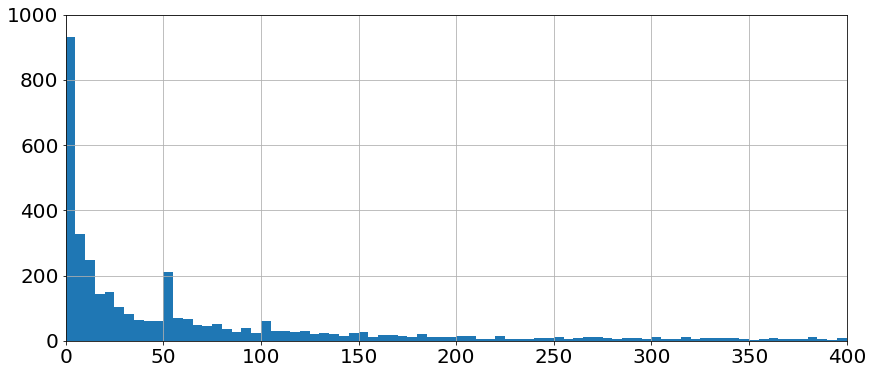

In [6]:
final_post_df['clap_count'].hist(bins = range(0,500,5), figsize=(14,6))
plt.xlim([0,400])
plt.ylim([0,1000])
plt.savefig('Success_datase2.png')

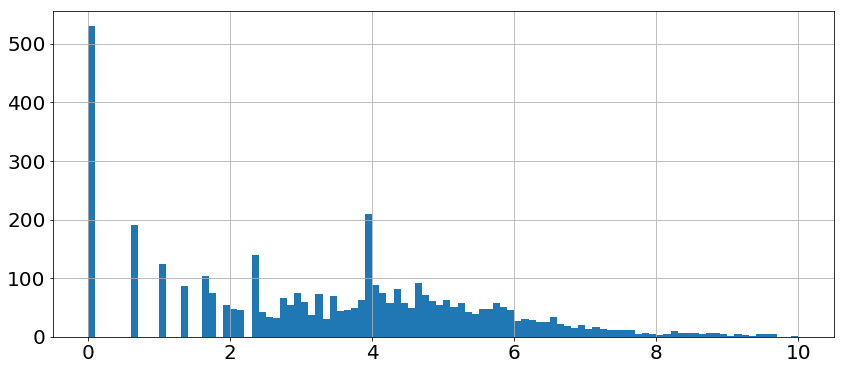

In [32]:
final_post_df['clap_count_log'].hist(bins = np.linspace(0,10,101), figsize=(14,6))


Success is defined differently for different topics. For each topic we defined a quartiles. The 0.8 quantile defines the number of claps needed for success. 

In [7]:
#%% Defining Success
tag_labels = final_post_df.post_tags.unique()
clap_target_q90 = final_post_df[['clap_count','post_tags']].groupby('post_tags').quantile(0.9)
clap_target_q80 = final_post_df[['clap_count','post_tags']].groupby('post_tags').quantile(0.8)

In [8]:
final_post_df['clap_target_q80'] = pd.Series()
final_post_df['clap_target_q90'] = pd.Series()
for tag in tag_labels:
    final_post_df.loc[final_post_df['post_tags']==tag,'clap_target_q90'] = clap_target_q90.loc[tag,'clap_count']
    final_post_df.loc[final_post_df['post_tags']==tag,'clap_target_q80'] = clap_target_q80.loc[tag,'clap_count']

In [9]:
train_df = final_post_df.copy()
train_df['y90'] = pd.to_numeric(final_post_df['clap_count'] > final_post_df['clap_target_q90'])
train_df['y80'] = pd.to_numeric(final_post_df['clap_count'] > final_post_df['clap_target_q80'])

We can see that the number of words (related to read time) contains some information of success 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


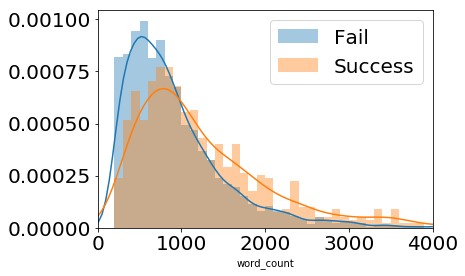

In [10]:
plt.figure(figsize=(6,4))
sns.distplot(train_df.loc[train_df['y80']==False,'word_count'], bins = range(0,4000,100))
sns.distplot(train_df.loc[train_df['y80'],'word_count'], bins = range(0,4000,100))
plt.xlim([0,4000])
plt.legend(['Fail','Success'])
plt.savefig('words.png')

### Engineering features related to word statistics
The number of words, sentences and syllables in the text are used to calculate readability metrics

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import cmudict
pronunciation_dictionary = cmudict.dict()

def not_punctuation(word):
    return not (len(word)==1 and (not word.isalpha()))

def get_word_count(text):
    words = word_tokenize(text)
    return len([word for word in words if not_punctuation(word)])

def get_syllable_count_word(word):
    try:
        syllables = pronunciation_dictionary[word.lower()][0]
    except KeyError:
        return 0
    return len([syllable for syllable in syllables if syllable.lower()[-1].isdigit()])
    
def get_syllable_count_text(text):
    words = word_tokenize(text)
    syllable_counts = [get_syllable_count_word(word) for word in words if not_punctuation(word)]
    return sum(syllable_counts)

def get_complex_word_count(text):
    words = word_tokenize(text)
    syllable_counts = [get_syllable_count_word(word) for word in words if not_punctuation(word)]
    return len([syllable_count for syllable_count in syllable_counts if syllable_count > 2])


In [17]:
def text_statistics(text):
    word_count = get_word_count(text)
    sentence_count = len(sent_tokenize(text))
    syllable_count = get_syllable_count_text(text)
    complex_word_count = get_complex_word_count(text)
    return word_count, sentence_count, syllable_count, complex_word_count

def flesch_kincaid_grade(text):
    word_count = get_word_count(text)
    sentence_count = len(sent_tokenize(text))
    syllable_count = get_syllable_count_text(text)
    return 0.39*word_count/sentence_count + 11.8*syllable_count/word_count - 15.59

def gunning_fog_grade(text):
    word_count = get_word_count(text)
    sentence_count = len(sent_tokenize(text))
    complex_word_count = get_complex_word_count(text)
    return 0.4*(word_count/sentence_count + 100*(complex_word_count/word_count))

In [18]:
train_df.columns

Index(['clap_count', 'detected_language', 'image_count', 'post_creatorId',
       'post_date', 'post_id', 'post_link_count', 'post_publication_id',
       'post_tags', 'post_url', 'publication_follower_count', 'read_time',
       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
       'archive_date', 'full_text', 'clap_target_q80', 'clap_target_q90',
       'y90', 'y80'],
      dtype='object')

In [19]:
train_df['FK_grade'] = train_df['full_text'].apply(flesch_kincaid_grade)
train_df['GF_grade'] = train_df['full_text'].apply(gunning_fog_grade)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


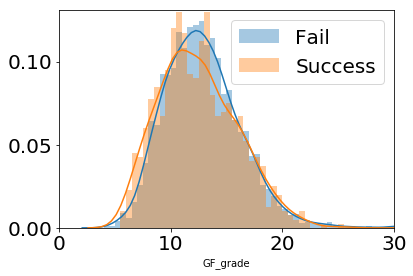

In [34]:
sns.distplot(train_df.loc[(train_df['y80']==False),'GF_grade'], bins = np.linspace(0,39.5,80))
sns.distplot(train_df.loc[train_df['y80'],'GF_grade'], bins = np.linspace(0,39.5,80))

plt.xlim([0,30])
plt.legend(['Fail','Success'])
plt.savefig('readability1.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


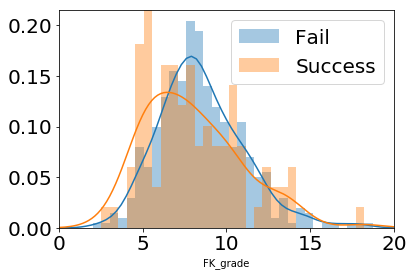

In [21]:
sns.distplot(train_df.loc[(train_df['y80']==False) & (train_df['post_tags']=='travel'),'FK_grade'], bins = np.linspace(0,40,80))
sns.distplot(train_df.loc[train_df['y80'] & (train_df['post_tags']=='travel'),'FK_grade'], bins = np.linspace(0,40,80))

plt.xlim([0,20])
plt.legend(['Fail','Success'])
plt.savefig('readability1.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


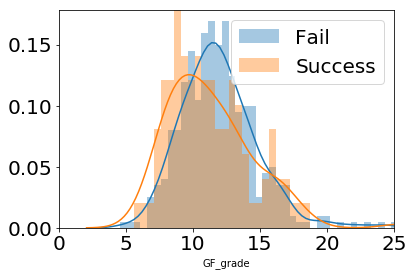

In [23]:
sns.distplot(train_df.loc[(train_df['y80']==False) & (train_df['post_tags']=='travel'),'GF_grade'], bins = np.linspace(0,40,80))
sns.distplot(train_df.loc[train_df['y80'] & (train_df['post_tags']=='travel'),'GF_grade'], bins = np.linspace(0,40,80))

plt.xlim([0,25])
plt.legend(['Fail','Success'])
plt.savefig('readability2.png')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


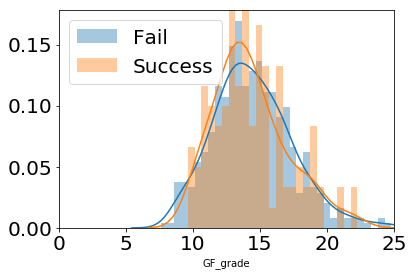

In [27]:
sns.distplot(train_df.loc[(train_df['y80']==False) & (train_df['post_tags']=='machine-learning'),'GF_grade'], bins = np.linspace(0,40,80))
sns.distplot(train_df.loc[train_df['y80'] & (train_df['post_tags']=='machine-learning'),'GF_grade'], bins = np.linspace(0,40,80))

plt.xlim([0,25])
plt.legend(['Fail','Success'])
plt.savefig('Readibility4_ML.png')

In [ ]:
analyser = SentimentIntensityAnalyzer()
train_df['com'] = pd.Series()
train_df['neg'] = pd.Series()
train_df['neu'] = pd.Series()
train_df['pos'] = pd.Series()
for ii in train_df.index:
    snt = analyser.polarity_scores(train_df['full_text'][ii])
    train_df.loc[ii,'com'] = snt['compound']
    train_df.loc[ii,'neg'] = snt['neg']
    train_df.loc[ii,'neu'] = snt['neu']
    train_df.loc[ii,'pos'] = snt['pos']


In [ ]:
train_df['question_count']= pd.Series()
for ii in train_df.index:
    train_df.loc[ii,'question_count'] = train_df.loc[ii,'full_text'].count('?')
    
train_df['title_wcount'] = train_df.title.apply(get_word_count) + train_df.subtitle.apply(get_word_count)


In [ ]:
train_df.columns

In [ ]:
#['clap_count', 'detected_language', 'image_count', 'post_creatorId',
#       'post_date', 'post_id', 'post_link_count', 'post_publication_id',
#       'post_tags', 'post_url', 'publication_follower_count', 'read_time',
#       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
#       'archive_date', 'full_text', 'clap_target', 'y', 'FK_grade', 'com',
#       'neg', 'neu', 'pos']
trainingdf = train_df.drop(['clap_count', 'detected_language', 'post_creatorId',
       'post_date', 'post_id', 'post_publication_id', 
       'post_tags', 'post_url', 
       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
       'archive_date', 'full_text', 'clap_target_q20', 'clap_target_q80', 'clap_target_q90',
                           'y80','y90','FK_grade','neg','pos'],axis=1).copy()


In [ ]:
trainingdf.head()

In [ ]:
X_raw = trainingdf.values
y = train_df['y80'].astype('int')

In [ ]:
#%% Machine Learning
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, precision_recall_fscore_support
h = .02  # step size in the mesh


In [ ]:
from sklearn.utils import class_weight
class_weight.compute_class_weight('balanced',classes=np.array([0,1]),y=y)

In [ ]:
qScaler = QuantileTransformer(output_distribution='uniform')
stdScaler = StandardScaler() 
X = qScaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)


In [ ]:
np.unique(y_train)

In [ ]:
#%%
names = ["Logistic Reg", "Naive Bayes", "Linear SVM", "Random Forest"]

classifiers = [
    LogisticRegression(class_weight='balanced'),
    GaussianNB(),
    SVC(kernel="rbf",class_weight='balanced',probability=True),
    RandomForestClassifier(max_depth=3, n_estimators=20, max_features=3, class_weight='balanced')]

models = [clf.fit(X_train, y_train) for clf in classifiers]



In [ ]:
scores = [clf.score(X_test, y_test) for clf in models]
print(scores)

In [ ]:
ii=0
for clf in models:
    y_pred = clf.predict(X_test)
    print(names[ii],recall_score(y_test, y_pred))
    ii=ii+1


In [ ]:
ii=0
for clf in models:
    y_pred = clf.predict(X_test)
    print(names[ii],precision_recall_fscore_support(y_test, y_pred))
    ii=ii+1

In [ ]:
ii=0
for clf in models:
    y_pred = clf.predict(X_test)
    print(names[ii],f1_score(y_test, y_pred))
    ii=ii+1

In [ ]:
# Predict class probabilities
ii=0
for clf in models:
    prob_y = clf.predict_proba(X)
    prob_y = [p[1] for p in prob_y]
    print(names[ii],roc_auc_score(y, prob_y))
    ii=ii+1
    

In [ ]:
trainingdf.columns

In [ ]:
#%%
clf = models[3]
#clf1 = SVC(kernel="linear",probability=True)
#clf1 = RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)
#clf1 = GradientBoostingClassifier(n_estimators=20)
#for i in range(2,4):
    #X_train, X_test, y_train, y_test = \
    #train_test_split(X, y, test_size=i/10, random_state=42)

    #clf.fit(X_train, y_train)
    #score = clf.score(X_test, y_test)
    #print(i/10,'score',score)
    #probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    #%%
from sklearn.metrics import roc_curve, auc
i=1
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print('roc',roc_auc)


In [ ]:
plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold (AUC = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC.png')


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
y_pred = clf.predict(X_test)
cnf_matrix  = confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
class_names = ['Success','Needs Work']

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the normalized confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
tr_matrix = cnf_matrix.copy()
tr_matrix[0][0] = cnf_matrix[1][1]#.transpose()
tr_matrix[0][1] = cnf_matrix[1][0]
tr_matrix[1][0] = cnf_matrix[0][1]#.transpose()
tr_matrix[1][1] = cnf_matrix[0][0]
#cnf_matrix = cnf_matrix.transpose()
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tr_matrix, classes=class_names, 
                      title='Normalized confusion matrix')

plt.savefig('confusion.png')

In [ ]:
features = trainingdf.columns
toppostdf80 = train_df.drop(train_df.loc[train_df.y80==0].index, axis=0).copy()
toppostdf90 = train_df.drop(train_df.loc[train_df.y90==0].index, axis=0).copy()
print(len(toppostdf80))
print(len(toppostdf90))
X80_raw = toppostdf80.drop(['clap_count', 'detected_language', 'post_creatorId',
       'post_date', 'post_id', 'post_publication_id', 
       'post_tags', 'post_url', 
       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
       'archive_date', 'full_text', 'clap_target_q20', 'clap_target_q80',
                            'clap_target_q90','y80','y90','FK_grade','neg','pos'],axis=1).values
X90_raw = toppostdf90.drop(['clap_count', 'detected_language', 'post_creatorId',
       'post_date', 'post_id', 'post_publication_id', 
       'post_tags', 'post_url', 
       'response_count', 'subtitle', 'title', 'unique_slug', 'word_count',
       'archive_date', 'full_text', 'clap_target_q20', 'clap_target_q80',
                            'clap_target_q90','y80','y90','FK_grade','neg','pos'],axis=1).values



In [ ]:
X90_raw

In [ ]:
#X80 = qScaler.transform(X80_raw).mean(axis=0)
X80 = qScaler.transform([X80_raw.mean(axis=0)])
#X90 = qScaler.transform(X90_raw).mean(axis=0)
X90 = qScaler.transform([X90_raw.mean(axis=0)])

In [ ]:
X80

In [ ]:
X[230]

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf.pkl') 
joblib.dump(qScaler,'qscl.pkl')
pickle.dump(X80,open('X80.p', "wb" ))
pickle.dump(X90,open('X90.p', "wb" ))
pickle.dump(feature_ranks,open('feature_ranks.p', "wb" ))


In [ ]:
#%%
top_articles = trainingdf.mean()
#%%
X_top = stdScl.transform([top_articles.values])
#y_predtop = clf.predict(X_top)


In [ ]:
feature_ranks = pd.DataFrame(
    clf.feature_importances_.T.ravel()[:len(features)],columns=['fval'],
    index=features
)
feature_ranks['order'] = range(len(feature_ranks))
print(feature_ranks.values)

In [ ]:
feature_ranks

In [ ]:
predictive_indexes = feature_ranks.sort_values(by='fval',ascending=False)['order'].values
#predictive_features
# List of meta features that were most predictive of funded projects
predictive_features = ['publication followers', 'read time', 'grade level',
                       'number of links', 'neutrality','sentiment','number of images','length title-subtitle','number of questions']
predictive_indexes


In [ ]:
feature_ranks1 = pd.Series(
    models[2].coef_.T.ravel()[:len(features)],
    index=features
)
print(feature_ranks1.values)

In [ ]:
# Compute the weighted score of the meta features of a project
user_article_score = np.multiply(
    [X[3500]],
    feature_ranks['fval'].values
)
#%%
# Compute the weighted score of the meta features of the average top project
top80_article_score = np.multiply(
    X80,
    feature_ranks['fval'].values
)
top90_article_score = np.multiply(
    X90,
    feature_ranks['fval'].values
)


In [ ]:
X_raw[3500]

In [ ]:
X80_raw.mean(axis=0)

In [ ]:
qScaler.transform([X_raw[230]])

In [ ]:
qScaler.transform([X80_raw.mean(axis=0)])

In [ ]:
X80

In [ ]:
user_article_score

In [ ]:
top80_article_score

In [ ]:
#%%
# Combine the weighted scores into a single DataFrame
messy = pd.DataFrame([user_article_score[0,predictive_indexes], top80_article_score[0,predictive_indexes],top90_article_score[0,predictive_indexes]],
                     index=['Your article', 'Top 20% articles', 'Top 10% articles']).T.reset_index()
#%%
# Transform the combined data into tidy format
tidy = pd.melt(
    messy,
    id_vars='index',
    value_vars=['Your article', 'Top 20% articles', 'Top 10% articles'],
    var_name=' '
)

In [ ]:
tidy

In [ ]:


#%%
# Draw a grouped bar plot of the weighted scores
fontsize = 12
plt.figure(figsize=(14,6))
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
sns.factorplot(
    data=tidy,
    y='index',
    x='value',
    hue=' ',
    kind='bar',
    size=4,
    aspect=2,
    palette='Set1',
    orient='h',
    legend_out=False
).set(
    xlabel='score',
    ylabel='features',
    xticks=[]
)
#%%
plt.yticks(range(len(predictive_features)),predictive_features)
plt.savefig('Features.png')
#%%
# Re-label the y-axis and reposition the legend
#labels = trainingdf.columns
#['hyperlinks', 'images', 'innovation words', 'exclamation marks','bolded text', 'length of description']
#plt.yticks(trainingdf.columns.values)
#plt.yticks(predictive_features)

#fig.ax.legend(loc='lower right');
plt.savefig('figure.png', bbox_inches='tight', dpi=300);


In [ ]:
clf.predict([X[3500]])

In [ ]:
 print(models[3].feature_importances_)

In [ ]:
print(trainingdf.columns)

In [ ]:
class_names = ['Fail','Success']
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular
class_names = ['Fail','Success']
X_raw = X
#from lime.lime_text import LimeTextExplainer
import lime.lime_tabular
explainer1 = lime.lime_tabular.LimeTabularExplainer(X, feature_names=trainingdf.columns, class_names=['fail','success'], discretize_continuous=True)
X1 = qScaler.transform(X_raw)
y_pred = models[3].predict(X1)


In [ ]:
i=2000
#exp = explainer.explain_instance(X, clf.predict_proba, num_features=6)
exp = explainer1.explain_instance(X1[i], models[3].predict_proba, num_features=4)
#print('Document id: %d' % )
print('Probability =', models[3].predict_proba([X1[i]]))
print('True class: %s' % y[i])


In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
trainingdf.index = range(len(trainingdf))
trainingdf.loc[i,:]

In [ ]:
clf.predict([X[230]])

In [ ]:
plt.figure(figsize=(15,2))
sns.distplot(train_df.loc[train_df['y_train']==False,'neg'], bins = np.linspace(0,1,100))
sns.distplot(train_df.loc[train_df['y_train'],'neg'], bins = np.linspace(0,1,100))
plt.legend(['Fail','Success'])
#plt.xlim([0,1])
plt.savefig('negative.png')


In [ ]:
plt.figure(figsize=(15,2))
sns.distplot(train_df.loc[train_df['y_train']==False,'neu'], np.linspace(0,1,50))
sns.distplot(train_df.loc[train_df['y_train'],'neu'], np.linspace(0,1,50))
plt.legend(['Fail','Success'])
plt.xlim([0,1])
plt.savefig('neutral.png')


In [ ]:
plt.figure(figsize=(15,2))
#sns.distplot(train_df.loc[train_df['y_train']==False,'com'], np.linspace(0,1,50))
sns.distplot(train_df.loc[train_df['y_train']==False,'com'])

#sns.distplot(train_df.loc[train_df['y_train'],'com'], np.linspace(0,1,50))
sns.distplot(train_df.loc[train_df['y_train'],'com'])
plt.legend(['Fail','Success'])
#plt.xlim([0,1])
plt.savefig('neutral.png')


In [ ]:
final_post_df.loc[3000,'publication_follower_count']

In [ ]:
final_post_df.loc[3000,'image_count']

In [ ]:
final_post_df.loc[3000,'post_link_count']

In [ ]:
clf0 = models[0]

In [ ]:
clf0.class_weight

In [ ]:
clf0.coef_

In [ ]:
clf.feature_importances_

In [ ]:
features

In [ ]:
original_order = ['number of images','number of links','publication followers', 'read time', 'grade level',
                       'sentiment','neutrality','number of questions','length title-subtitle']
plt.bar(range(9),clf0.coef_[0])
plt.xticks(range(9),original_order,rotation='vertical')

plt.savefig('LR_coefficients.png',bbox_inches='tight', dpi=300)

In [ ]:
plt.bar(range(9),clf.feature_importances_)
plt.xticks(range(9),original_order,rotation='vertical')
plt.savefig('RF_coefficients.png',bbox_inches='tight', dpi=300)